# Домашнее задание ШАД МТС по теме ТВиМС 3

## Задание

Необходимо выбрать вероятностное распределение на ваш выбор, кроме самых простых (нормальное, равномерное, биномиальное) и в Jupyter Notebook (можно Google Colab) провести следующие эксперименты:

1. Для выбранного распределения сгенерируйте выборки разного объема и проиллюстрируйте сходимость выборочного среднего к математическому ожиданию (покажите наглядно стабилизацию выборочного среднего).
2. Наглядно продемонстрируйте центральную предельную теорему в действии для выбранного вами распределения (покажите сходимость с ростом выборки к нормальному распределению).

Сгенерируйте выборки маленького/среднего/большого размера и для каждой из них постройте:
- асимптотический доверительный интервал для среднего значения на базе ЦПТ,
- точный доверительный интервал для среднего значения,
- эфронов доверительный интервал для среднего, медианы, моды, дисперсии.

Представьте по пунктам 3-5 сводный датафрейм в читабельном формате и предоставьте вывод о ширинах ДИ, есть ли соответствие фактическому распределению, откуда взята выборка.

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
%matplotlib inline

### Сходимость

In [2]:
# Будем использовать распределение Фишера с параметрами k = 24 и m = 12

k, m = 24, 12

# размеры выборок
dist_size = [100, 500, 1000, 10000, 100000, 1000000]

expected_mean = sts.f.mean(k, m, loc=0, scale=1)

for n in dist_size:
    r = sts.f.rvs(k, m, size=n)
    print(f'Distribution size: {n}')
    print(f'Expected mean: {expected_mean}')
    print(f'Real mean: {r.mean()}\n')

Distribution size: 100
Expected mean: 1.2
Real mean: 1.0085196076999952

Distribution size: 500
Expected mean: 1.2
Real mean: 1.1908099078407912

Distribution size: 1000
Expected mean: 1.2
Real mean: 1.1892923899956602

Distribution size: 10000
Expected mean: 1.2
Real mean: 1.212360256680957

Distribution size: 100000
Expected mean: 1.2
Real mean: 1.2036997348515812

Distribution size: 1000000
Expected mean: 1.2
Real mean: 1.200074745824461



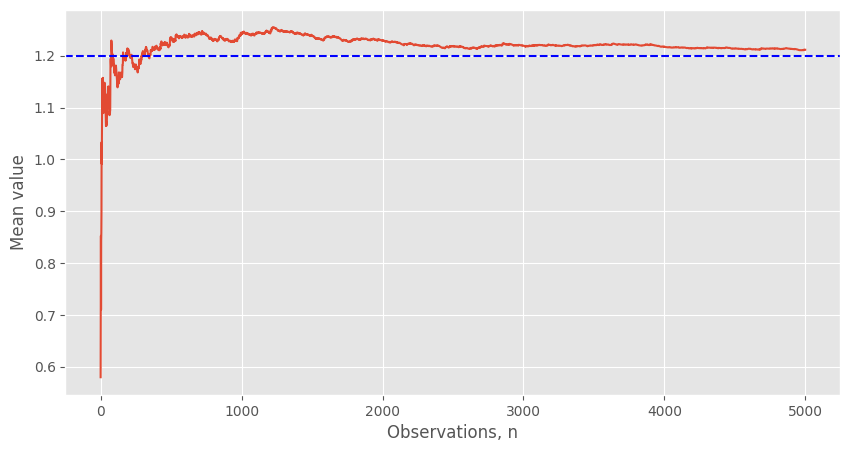

In [3]:
# иллюстрация сходимости на графике

n = 5000

r = sts.f.rvs(k, m, size=n)
r_mean = np.cumsum(r) / np.arange(1, n + 1)

plt.figure(figsize=(10,5))
plt.plot(r_mean)
plt.axhline(expected_mean, color='blue', linestyle='--')
plt.xlabel('Observations, n')
plt.ylabel('Mean value');

***
### ЦПТ

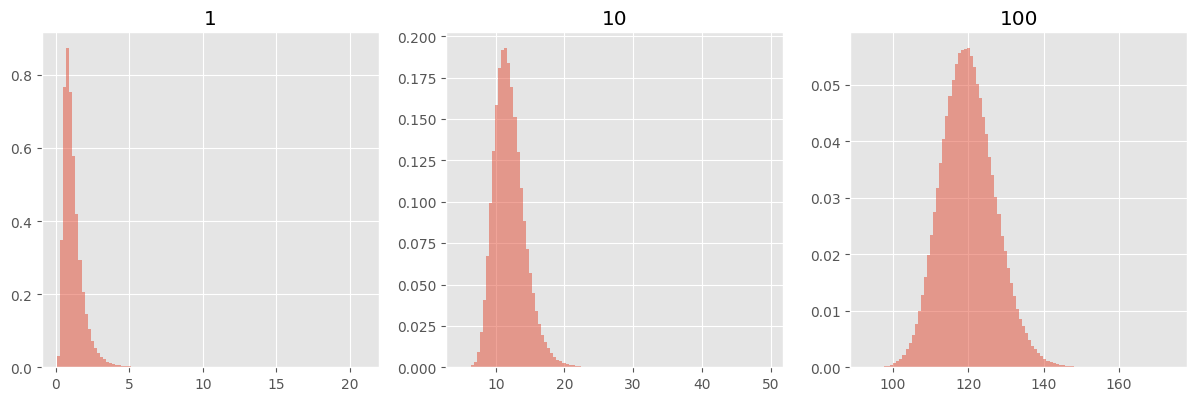

In [4]:
n = 1000000 # количество наблюдений
n_dist = 101 # количество сгенерированных выборок
r = np.array([0.0 for i in range(1, n + 1)])

plt.figure(figsize=(20,20))

for i in range(1, n_dist):
    r += sts.f.rvs(k, m, size=n)
    if i == 1:
        plt.subplot(4, 4, 1)
        plt.hist(r, density=True, bins=100, histtype='stepfilled', alpha=0.5)
        plt.title(i)
    elif i == 10:
        plt.subplot(4, 4, 2)
        plt.hist(r, density=True, bins=100, histtype='stepfilled', alpha=0.5)
        plt.title(i)
    elif i == 100:
        plt.subplot(4, 4, 3)
        plt.hist(r, density=True, bins=100, histtype='stepfilled', alpha=0.5)
        plt.title(i)

plt.show()

**Вывод:** при увеличении количества распределений Фишера в сумме, итоговое распределение стремится к нормальному
***

### Доверительные интервалы

In [5]:
# сгенерируем выборки малого, среднего и большого размера

alpha = 0.05
k, m = 24, 12
n = [50, 1000, 100000]

r_small = sts.f.rvs(k, m, size=n[0])
r_medium = sts.f.rvs(k, m, size=n[1])
r_big = sts.f.rvs(k, m, size=n[2])

r = []
r.append(r_small)
r.append(r_medium)
r.append(r_big)

final_stat = pd.DataFrame()

# определеим функции нахождения доверительных интервалов

def asympt_ci(r, alpha=0.05):
    """Асимптотический доверительный интервал для среднего значения на базе ЦПТ"""
    q = sts.norm.ppf(1 - alpha /  2)

    left = np.mean(r) - q * np.sqrt(np.var(r) / r.shape[0])
    right = np.mean(r) + q * np.sqrt(np.var(r) / r.shape[0])

    return left, right

def mean_ci(r, alpha=0.05):
    """Точный доверительный интервал для среднего значения"""
    return sts.t.interval(1 - alpha, len(r)-1, loc=np.mean(r), scale=sts.sem(r))

def bootstrap_ci(r, type='mean', iter=1000, alpha=0.05):
    """Эфронов доверительный интервал"""
    r_list = []
    for i in range(iter + 1):
        r_ = np.random.choice(r, size=r.shape[0], replace=True)
        if type == 'mode':
            r_list.append(sts.mode(r_)[0])
        elif type == 'median':
            r_list.append(np.median(r_))
        elif type == 'var':
            r_list.append(np.var(r_))
        else:
            r_list.append(np.mean(r_))
    left, right = np.percentile(r_list, q=[round(alpha*50, 1), round(100 - alpha*50, 1)])
    return left, right

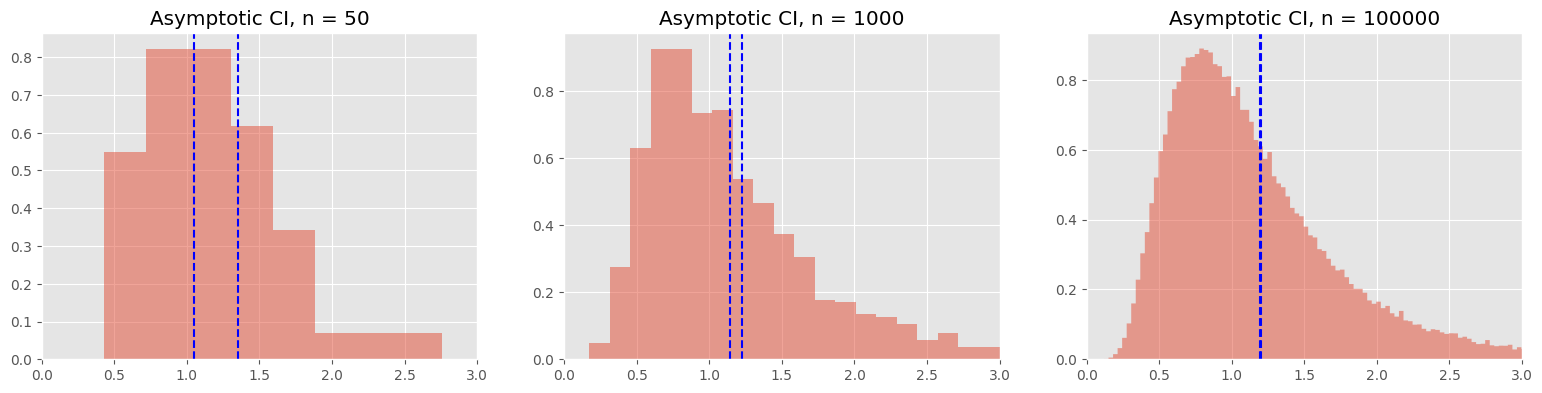

In [6]:
# Асимптотический доверительный интервал для среднего значения на базе ЦПТ

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = asympt_ci(r[i], alpha)
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Asymptotic CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Asymptotic mean CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

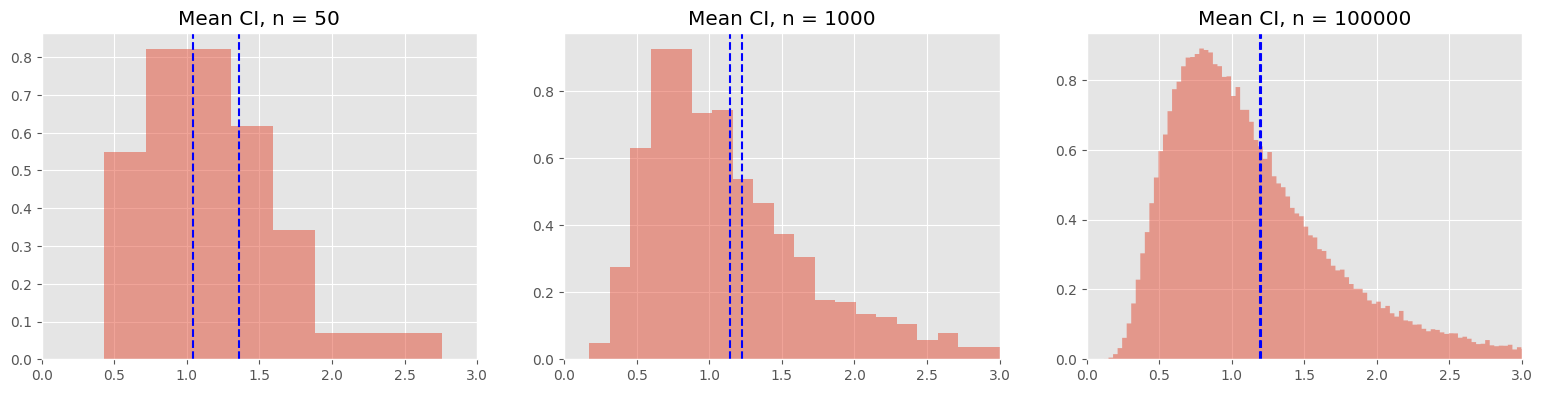

In [7]:
# Точный доверительный интервал для среднего значения

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = mean_ci(r[i])
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Mean CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Mean CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

***

### Эфронов доверительный интервал для среднего, медианы, моды, дисперсии

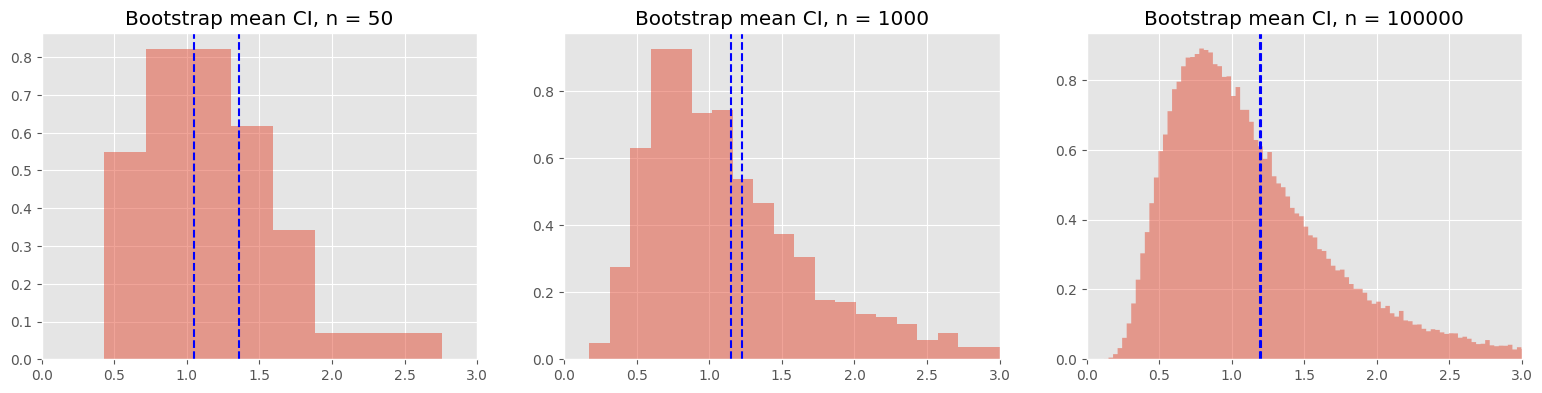

In [8]:
# Эфронов доверительный интервал для среднего значения

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = bootstrap_ci(r[i], type='mean')
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Bootstrap mean CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Bootstrap mean CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

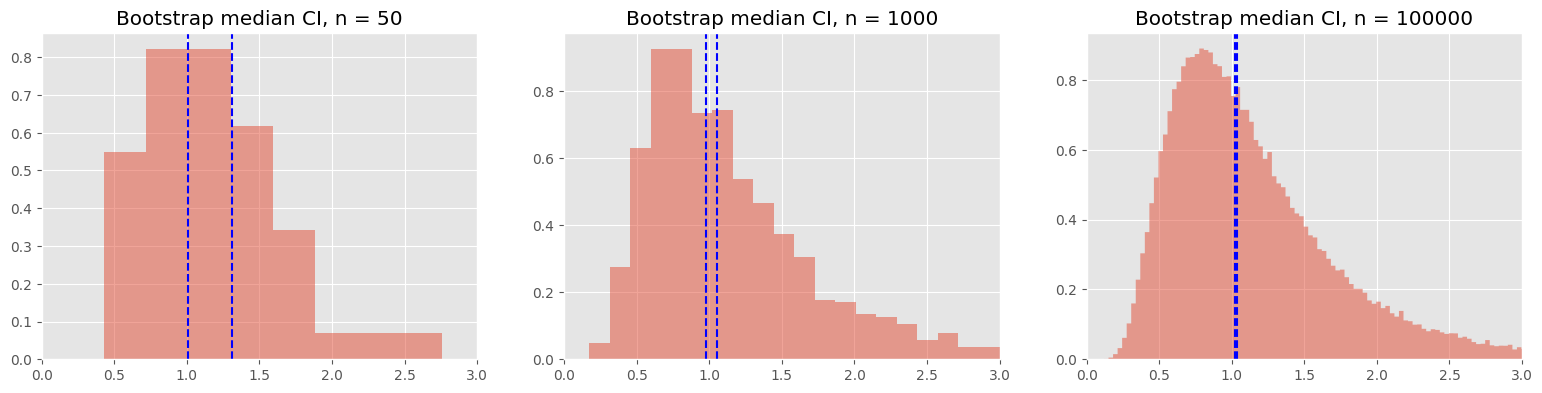

In [9]:
# Эфронов доверительный интервал для медианного значения

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = bootstrap_ci(r[i], type='median')
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Bootstrap median CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Bootstrap median CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

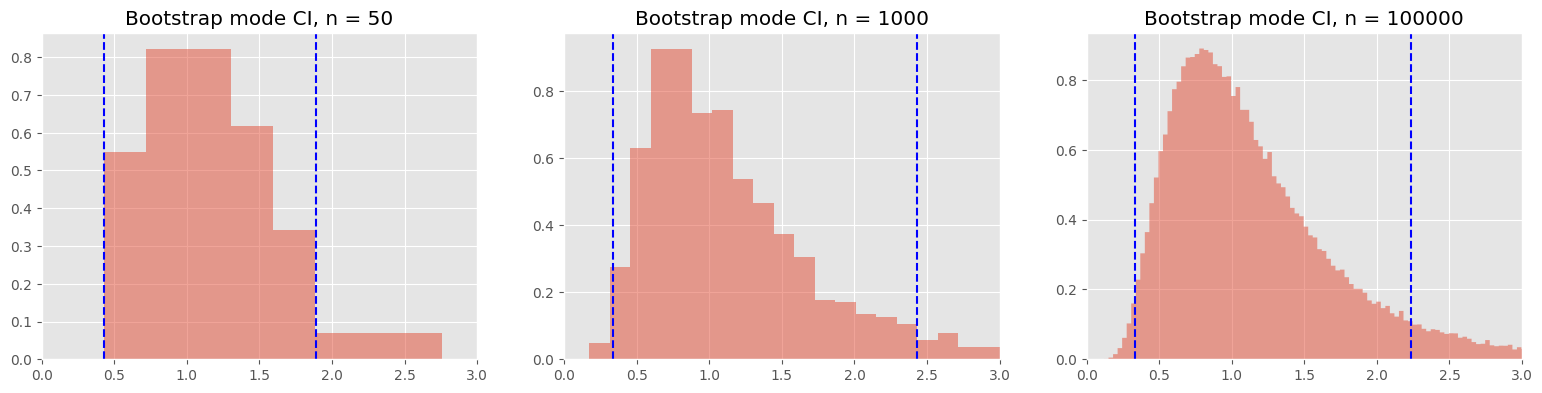

In [10]:
# Эфронов доверительный интервал для моды

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = bootstrap_ci(r[i], type='mode')
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Bootstrap mode CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Bootstrap mode CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

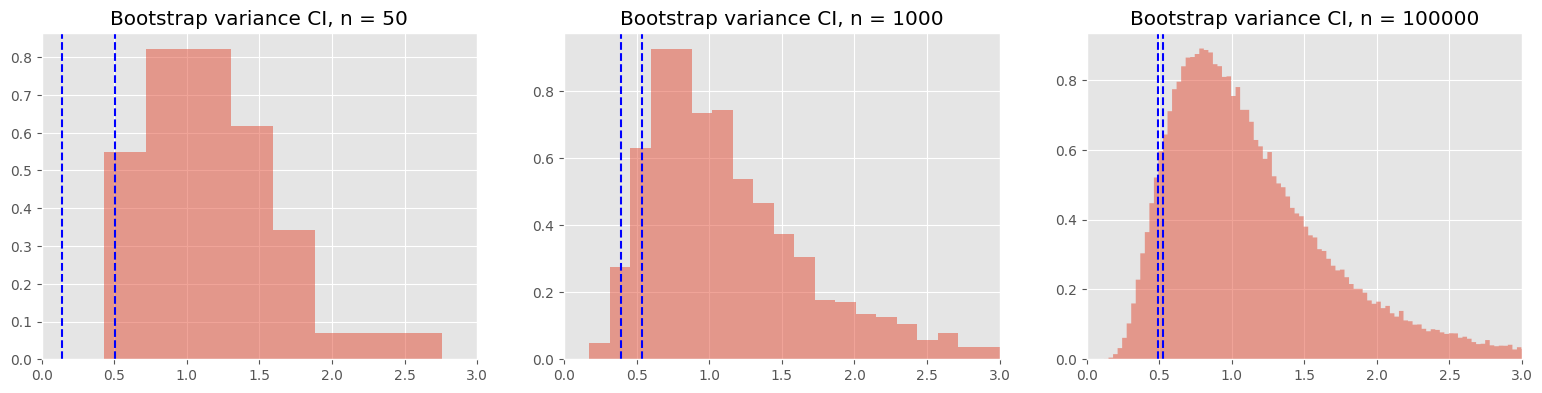

In [11]:
# Эфронов доверительный интервал для дисперсии

plt.figure(figsize=(100,50))

for i in range(len(n)):
    left, right = bootstrap_ci(r[i], type='var')
    plt.subplot(10, 15, i+1)
    plt.hist(r[i], density=True, bins='auto', histtype='stepfilled', alpha=0.5)
    plt.xlim(0, 3)
    plt.axvline(left, color='blue', linestyle='--')
    plt.axvline(right, color='blue', linestyle='--')
    plt.title(f'Bootstrap variance CI, n = {n[i]}')

    # добавление статистики в итоговый датафрейм
    row = {}
    row['Sample size'] = n[i]
    row['Interval'] = 'Bootstrap variance CI'
    row['Left'] = round(left, 4)
    row['Right'] = round(right, 4)
    row['Diff'] = round(right - left, 4)
    row_df = pd.DataFrame([row])
    final_stat = pd.concat([final_stat, row_df])
plt.show()

In [12]:
final_stat

,Sample size,Interval,Left,Right,Diff
0,50,Asymptotic mean CI,1.0462,1.3550,0.3088
0,1000,Asymptotic mean CI,1.1437,1.2280,0.0844
0,100000,Asymptotic mean CI,1.1932,1.2021,0.0088
0,50,Mean CI,1.0407,1.3605,0.3199
0,1000,Mean CI,1.1436,1.2281,0.0845
0,100000,Mean CI,1.1932,1.2021,0.0088
0,50,Bootstrap mean CI,1.0500,1.3613,0.3113
0,1000,Bootstrap mean CI,1.1477,1.2248,0.0771
0,100000,Bootstrap mean CI,1.1934,1.2021,0.0088
0,50,Bootstrap median CI,1.0073,1.3087,0.3014
